In [3]:
import json

summaries = []
with open("community_summaries_cleaned.jsonl", "r") as f:
    for line in f:
        summaries.append(json.loads(line))

print(f"Loaded {len(summaries)} summaries")
print(summaries[0])  # peek at the first entry


Loaded 1437 summaries
{'communityId': '103', 'mofs': ['ULOKAJ', 'MIMVIN', 'LUMYID', 'QIWDOR', 'QEZBUV', 'BAMKIM', 'CAQSUK', 'PUDRIQ', 'ETIXIQ', 'ICIKEL'], 'applications': [], 'properties': ['Space Group: C2/c '], 'summary': 'Community ID 103 clusters MOFs that exhibit significant potential for **guest encapsulation**, suggesting applications in **drug delivery** or **sensing**. The recurring **property** of crystallization in the **C2/c space group** indicates a common structural framework that supports the formation of stable, porous networks, which is essential for accommodating various guest molecules. \n\nThe **structural similarities** include the use of **square planar metal nodes** (e.g., Zn) and a consistent topology (42.84 and 44), which enhances the stability and functionality of these MOFs. This shared architecture likely facilitates similar guest-host interactions, allowing for tailored modifications to optimize performance in specific applications. \n\nThe interplay betwee

Total docs: 1437
Avg tokens: 5226.5
Max tokens: 24053


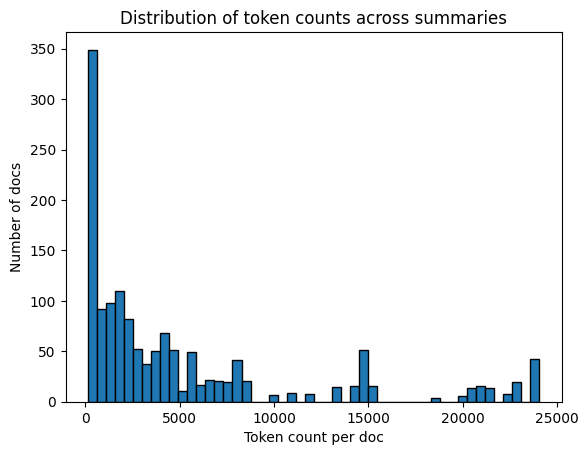

In [5]:
import tiktoken
import matplotlib.pyplot as plt

# choose tokenizer for your embedding model
enc = tiktoken.encoding_for_model("text-embedding-3-small")

token_counts = []
for s in summaries:
    text = f"""
MOF Names: {', '.join(s.get('mof_names', []))}
Summary: {s['summary']}
""".strip()
    n_tokens = len(enc.encode(text))
    token_counts.append(n_tokens)

# quick stats
print(f"Total docs: {len(token_counts)}")
print(f"Avg tokens: {sum(token_counts)/len(token_counts):.1f}")
print(f"Max tokens: {max(token_counts)}")

# Plot histogram
plt.hist(token_counts, bins=50, edgecolor="black")
plt.xlabel("Token count per doc")
plt.ylabel("Number of docs")
plt.title("Distribution of token counts across summaries")
plt.show()


We wanted to include MOF names in the embedding to help with specific retrieval, but they are putting us over the token limit in vector indices when there are several MOFs in a community. Luckily, these are the communities where name-specific vector search is less important, so, we'll take names out of the vectore store for communities with more than 10 MOFs

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.docstore.document import Document

# --- Build documents with MOF name cutoff ---
docs = []
for s in summaries:
    all_mofs = s.get("mofs", [])
    n_mofs = len(all_mofs)

    if n_mofs <= 10:
        mof_text = f"MOFs: {', '.join(all_mofs)}"
    else:
        mof_text = "MOFs: [list omitted due to large community size]"

    text = f"""
Community ID: {s['communityId']}
{mof_text}
Summary: {s['summary']}
""".strip()

    docs.append(Document(
        page_content=text,
        metadata={
            "communityId": s["communityId"],
        }
    ))

# --- Embeddings ---
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# --- Chroma persistent vector store ---
persist_dir = "./chroma_db_mof_summaries"

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory=persist_dir  # saves the DB so you can reload later
)

# --- Save the index ---
vectorstore.persist()

/var/folders/_l/c6v61_8n51j1d1jwmssq4ndw0000gn/T/ipykernel_45751/2788258517.py:42: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [21]:
# --- Create retriever ---
summary_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)


In [ ]:
'''vectorstore = Chroma(
    embedding_function=embeddings,
    persist_directory=persist_dir
)
summary_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})'''


Lets demo a retrieval!

In [16]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are an expert chemist specializing in Metal–Organic Frameworks (MOFs). "
     "You have access to curated community summaries that group MOFs by shared properties, "
     "applications, and structural features. "
     "Your task is to use these summaries as context to infer scientific insights and answer the user’s question.\n\n"
     "Guidelines:\n"
     "- Identify and explain patterns (e.g., why certain MOFs are clustered together).\n"
     "- Make inferences about application–property–structure relationships.\n"
     "- Be concise, factual, and use technical terminology appropriate for a materials scientist.\n"
     "- If the context does not fully answer the question, say so explicitly and suggest what is known.\n"
     "- Always ground your reasoning in the retrieved community summaries.\n"
    ),
    ("user", "Question: {question}\n\nContext:\n{context}")
])

qa_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-4o-mini", temperature=0.2),
    retriever=summary_retriever,
    return_source_documents=True,
    chain_type="stuff",
    chain_type_kwargs={
        "prompt": rag_prompt,
        "document_variable_name": "context"
    }
)


In [23]:
query = "Which MOFs are good for CO₂ capture?"
result = qa_chain.invoke({"query": query})

print("Answer:\n", result["result"])
print("\n--- Sources ---")
for doc in result["source_documents"]:
    print("Community:", doc.metadata["communityId"])
    print("Snippet:", doc.page_content[:300], "...\n")


Answer:
 The MOFs identified in the provided summaries are particularly well-suited for CO₂ capture due to several shared properties and structural features. 

1. **High Selectivity for CO₂**: All three communities emphasize the high selectivity of these MOFs for CO₂ uptake, which is crucial for effective separation from gas mixtures. This selectivity is often a result of the specific interactions between the metal nodes (like Cr and Mo) and the organic linkers, which enhance the framework's affinity for CO₂ over other gases such as N₂.

2. **Structural Characteristics**: A common structural motif among these MOFs is the uninodal 6-connected topology, often utilizing "mmo" nets and MO4^2– pillars. This structural uniformity contributes to the stability and robustness of the frameworks, which is essential for maintaining performance during gas adsorption processes.

3. **High Surface Area and Tailored Pore Sizes**: The MOFs in these communities are characterized by high surface areas an

In [27]:
query = "What makes a MOF water stable?"
result = qa_chain.invoke({"query": query})

print("Answer:\n", result["result"])
print("\n--- Sources ---")
for doc in result["source_documents"]:
    print("Community:", doc.metadata["communityId"])
    print("Snippet:", doc.page_content[:300], "...\n")


Answer:
 Water stability in Metal–Organic Frameworks (MOFs) is influenced by several structural and compositional factors that enhance their resilience in humid or aqueous environments. Based on the community summaries provided, we can infer the following key aspects that contribute to the water stability of MOFs:

1. **Metal Nodes**: The choice of metal nodes plays a significant role in determining the stability of MOFs in water. For instance, metals like magnesium (Mg) and aluminum (Al), which are mentioned in the context of community ID 16580, tend to form more stable coordination bonds with organic linkers, enhancing the overall structural integrity of the framework in the presence of moisture.

2. **Organic Linkers**: The type of organic linkers used can also affect water stability. Linkers that are more hydrophobic or have functional groups that can withstand hydrolysis are preferable. The use of pyridinedicarboxylic acid in community ID 16580 suggests that such linkers may contr

In [26]:
query = "Which MOFs are good for CO₂ capture?"
result = qa_chain.invoke({"query": query})

print("Answer:\n", result["result"])
print("\n--- Sources ---")
for doc in result["source_documents"]:
    print("Community:", doc.metadata["communityId"])
    print("Snippet:", doc.page_content[:300], "...\n")


Answer:
 Based on the summaries from the three community IDs focused on MOFs for CO₂ capture, several patterns and insights can be drawn regarding their properties, structures, and applications:

1. **Common Structural Features**: 
   - Many of the MOFs in these communities utilize uninodal 6-connected topologies, often referred to as "mmo" nets, which are characterized by their robust frameworks. The use of metal nodes such as chromium (Cr) and molybdenum (Mo) is prevalent, contributing to the structural integrity and stability of the MOFs during gas adsorption processes.

2. **High Selectivity and Adsorption Properties**: 
   - The MOFs exhibit high selectivity for CO₂, which is crucial for effective separation from gas mixtures. This selectivity is often linked to their high surface areas and tailored pore sizes, allowing for efficient gas adsorption. The favorable isosteric heats of adsorption (Qst) indicate strong interactions with CO₂, enhancing their performance in carbon captur

In [25]:
query = "how can I synthesize MOF mg-mof-74 to be more selective to CO2 in flue gas"
result = qa_chain.invoke({"query": query})

print("Answer:\n", result["result"])
print("\n--- Sources ---")
for doc in result["source_documents"]:
    print("Community:", doc.metadata["communityId"])
    print("Snippet:", doc.page_content[:300], "...\n")

Answer:
 To synthesize Mg-MOF-74 with enhanced selectivity for CO2 in flue gas, consider the following strategies based on insights from the community summaries:

1. **Metal Node Selection**: While Mg is already a favorable choice due to its lightweight and cost-effective nature, exploring the incorporation of other metal nodes (e.g., Cr or Mo) in the synthesis could enhance the framework's stability and selectivity for CO2. These metals have been shown to improve the robustness of MOFs and their gas adsorption capabilities.

2. **Organic Linker Modification**: Tailoring the organic linkers used in Mg-MOF-74 can significantly influence the pore size and surface area, both of which are critical for selective gas adsorption. Using linkers that promote a more flexible framework could enhance the "breathing" effect, allowing for better accommodation of CO2 molecules compared to other gases like N2.

3. **Pore Size Optimization**: The community summaries emphasize the importance of tailored